Import Library useful

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Imputation of missing values
from sklearn.impute import KNNImputer, SimpleImputer

#Preprocessing scaler, one-hot
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler, MaxAbsScaler

#Model
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics and graph
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

from timeit import default_timer as timer
import psutil
from collections import Counter
%matplotlib inline

Import data and description

In [2]:
#data link https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29\n",
# header_column = ["Status of existing checking account",
#                 "Duration in month",
#                 "Credit history",
#                 "Purpose",
#                 "Credit amount",
#                 "Savings account/bonds",
#                 "Present employment since",
#                 "Installment rate in percentage of disposable income",
#                 "Personal status and sex",
#                 "Other debtors / guarantors",
#                 "Present residence since",
#                 "Property",
#                 "Age in years",
#                 "Other installment plans",
#                 "Housing",
#                 "Number of existing credits at this bank",
#                 "Job",
#                 "Number of people being liable to provide maintenance for",
#                 "Telephone",
#                 "foreign worker",
#                 "actual classification"]
data = pd.read_csv("./data/german_clean.csv")
df = pd.DataFrame(data = data)

#Check data
df.head()

,status,duration,credit_history,purpose,credit_amount,savings_account,present_employment,installment_rate,personal_status_sex,guarantors,...,property,age,installment_plan,housing,existing_credits,job,liables,telephone,foreign,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   status               995 non-null    object
 1   duration             995 non-null    int64 
 2   credit_history       995 non-null    object
 3   purpose              995 non-null    object
 4   credit_amount        995 non-null    int64 
 5   savings_account      995 non-null    object
 6   present_employment   995 non-null    object
 7   installment_rate     995 non-null    int64 
 8   personal_status_sex  995 non-null    object
 9   guarantors           995 non-null    object
 10  residence            995 non-null    int64 
 11  property             995 non-null    object
 12  age                  995 non-null    int64 
 13  installment_plan     995 non-null    object
 14  housing              995 non-null    object
 15  existing_credits     995 non-null    int64 
 16  job     

Change object -> category

: Category dtype better than object when you train model.

In [4]:
#Change dtype object -> category
df_cat = df.copy()
for col_name in df_cat.columns:
    if np.dtype(df_cat[col_name]) == "object":
        df_cat[col_name] = df_cat[col_name].astype("category")
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   status               995 non-null    category
 1   duration             995 non-null    int64   
 2   credit_history       995 non-null    category
 3   purpose              995 non-null    category
 4   credit_amount        995 non-null    int64   
 5   savings_account      995 non-null    category
 6   present_employment   995 non-null    category
 7   installment_rate     995 non-null    int64   
 8   personal_status_sex  995 non-null    category
 9   guarantors           995 non-null    category
 10  residence            995 non-null    int64   
 11  property             995 non-null    category
 12  age                  995 non-null    int64   
 13  installment_plan     995 non-null    category
 14  housing              995 non-null    category
 15  existing_credits     99

***Actual class 

: 0 -> bad

: 1 -> good

Data management

In [5]:
#When you random value from library, A values will be same point at the different time.
SEED = 42 

#Define target and feature from dataframe.
TARGET = "class"
FEATURES = df_cat.columns.drop(TARGET)

#Select data columns name only dtype 'number'
NUMERICAL = df_cat[FEATURES].select_dtypes('number').columns

#Select data coulumn name only dtype 'category'
CATEGORICAL = pd.Index(np.setdiff1d(FEATURES, NUMERICAL)) # np.setdiff1d(a, b) -> return unique values in a that b value not in a Ex. [1, 2, 3], [3, 4] => [1, 2]

#Change string to float
for column_name in df_cat[CATEGORICAL]:
    df_cat[column_name] = df_cat[column_name].cat.codes

#Change Class 0-> bad, 1-> good
for index, val in enumerate(df_cat["class"]):
    if val == 2:
        df_cat["class"][index] = 0

input = df_cat.drop(columns=TARGET)
target = df_cat[TARGET]

Pipline

In [6]:
#Numerical_pipline
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), #Method to solve missing values
    ('scaler', MinMaxScaler()) #Change scale on data
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant')),
    ('encoder', OneHotEncoder())  #Extract data to one-hot to each columns
])

#numerical and cateforical add to preprocessor
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numerical_pipe, NUMERICAL),
    ('cat', categorical_pipe, CATEGORICAL)
])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=.2, random_state=SEED, 
                                    stratify=df_cat[TARGET]) #Dividing data to train and test set

In [8]:
target_names = ['bad', 'good']
print("Memory Usage : {:.2f}MB".format(psutil.Process().memory_info().rss / (1024*1024)))

Memory Usage : 166.34MB


Extreme Gradient Boosting

In [9]:
#Create Pipline of model
print('For Normal data :')
XGB_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier())
])

#Train model
nor_start_mem = psutil.Process().memory_info().rss / (1024*1024)
nor_start= timer()
XGB_pipeline.fit(X_train, y_train)
nor_end = timer()
nor_end_mem = psutil.Process().memory_info().rss / (1024*1024)

print("Time taken: {} s".format(round(nor_end-nor_start,5)))
print("Memory Usage : {:.3f}MB".format(nor_end_mem - nor_start_mem))

For Normal data :
Time taken: 0.16104 s
Memory Usage : 11.000MB


In [10]:
#Predictation of model to test dataset and measure
y_pred = XGB_pipeline.predict(X_test)
accuracy = XGB_pipeline.score(X_test, y_test)

print("accuracy: ",accuracy)
print("f1_score: ",f1_score(y_test, y_pred, average="weighted"))

#Check confusiong matrix
print(classification_report(y_test, y_pred, target_names=target_names))

accuracy:  0.7688442211055276
f1_score:  0.7621280091389258
              precision    recall  f1-score   support

         bad       0.63      0.53      0.57        59
        good       0.81      0.87      0.84       140

    accuracy                           0.77       199
   macro avg       0.72      0.70      0.71       199
weighted avg       0.76      0.77      0.76       199



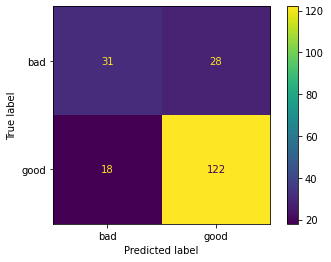

Total test data ->  199


In [11]:
#Visualization confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=target_names)
disp = disp.plot()
plt.show()
print("Total test data -> ", X_test.shape[0])

In [12]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [13]:
ros = RandomOverSampler(random_state=SEED)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)
print('Over sampled class distribution : ',sorted(Counter(y_oversampled).items()))

print('For OverSampling data :')
over_XGB_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier())
])

#Train model
over_start_mem = psutil.Process().memory_info().rss / (1024*1024)
over_start= timer()
over_XGB_pipeline.fit(X_oversampled, y_oversampled)
over_end = timer()
over_end_mem = psutil.Process().memory_info().rss / (1024*1024)

print("Time taken: {} s".format(round(over_end-over_start,5)))
print("Memory Usage : {:.3f}MB".format(over_end_mem - over_start_mem))
print("")

#Predictation of model to test dataset and measure
over_y_pred = over_XGB_pipeline.predict(X_test)
accuracy = over_XGB_pipeline.score(X_test, y_test)

print("accuracy: ",accuracy)
print("f1_score: ",f1_score(y_test, over_y_pred, average="weighted"))

#Check confusiong matrix
print(classification_report(y_test, over_y_pred, target_names=target_names))

Over sampled class distribution :  [(0, 558), (1, 558)]
For OverSampling data :
Time taken: 0.14188 s
Memory Usage : 2.488MB

accuracy:  0.7336683417085427
f1_score:  0.7355277446395985
              precision    recall  f1-score   support

         bad       0.55      0.58      0.56        59
        good       0.82      0.80      0.81       140

    accuracy                           0.73       199
   macro avg       0.68      0.69      0.69       199
weighted avg       0.74      0.73      0.74       199



In [14]:
ros = RandomUnderSampler(random_state=SEED)
X_undersampled, y_undersampled = ros.fit_resample(X_train, y_train)
print('Under sampled class distribution : ',sorted(Counter(y_undersampled).items()))

print('For OverSampling data :')
under_XGB_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier())
])

#Train model
under_start_mem = psutil.Process().memory_info().rss / (1024*1024)
under_start= timer()
under_XGB_pipeline.fit(X_undersampled, y_undersampled)
under_end = timer()
under_end_mem = psutil.Process().memory_info().rss / (1024*1024)

print("Time taken: {} s".format(round(under_end-under_start,5)))
print("Memory Usage : {:.10f}MB".format(under_end_mem - under_start_mem))
print("")

#Predictation of model to test dataset and measure
under_y_pred = under_XGB_pipeline.predict(X_test)
accuracy = under_XGB_pipeline.score(X_test, y_test)

print("accuracy: ",accuracy)
print("f1_score: ",f1_score(y_test, under_y_pred, average="weighted"))

#Check confusiong matrix
print(classification_report(y_test, under_y_pred, target_names=target_names))

Under sampled class distribution :  [(0, 238), (1, 238)]
For OverSampling data :
Time taken: 0.09304 s
Memory Usage : 0.0000000000MB

accuracy:  0.678391959798995
f1_score:  0.6899491922514008
              precision    recall  f1-score   support

         bad       0.47      0.64      0.54        59
        good       0.82      0.69      0.75       140

    accuracy                           0.68       199
   macro avg       0.65      0.67      0.65       199
weighted avg       0.72      0.68      0.69       199

